In [1]:
import os, glob
import numpy as np
import pandas as pd
from scipy import stats
w_list= glob.glob("../result/merge_weather/*.csv")
pd.set_option('display.max_rows', 20)
# flowers = []
# for fn in get_f_list:
#     flowers.append(fn.split("\\")[-1].split("_")[0])

# flower = flowers[0]
# fn_list = glob.glob("../result/merge_flower_price/*" + flower + "*.csv")
w_list

['../result/merge_weather\\467480_嘉義.csv',
 '../result/merge_weather\\C0F9L0_后里.csv',
 '../result/merge_weather\\C0G650_員林.csv',
 '../result/merge_weather\\C0H960_草屯.csv',
 '../result/merge_weather\\C0K490_古坑.csv',
 '../result/merge_weather\\C0R590_里港.csv',
 '../result/merge_weather\\C0V360_內門.csv',
 '../result/merge_weather\\C0X060_下營.csv']

In [2]:
from datetime import date, time, datetime
from datetime import timedelta

fn_raw = w_list[3]
r_data = pd.read_csv(fn_raw, encoding="utf-8")
data_t_n = ['Temperature', 'RH', 'StnPres', 'WS', 'WSGust','d_tmp']
col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
# rm "/"
for col in col_fix:
    old = r_data[col]
    new = []
    for i in range(len(old)):
        try:
            new.append(float(old[i]))
            tmp = float(old[i])
        except ValueError:
            new.append(tmp)
    r_data[col] = new
rain  = r_data['Precp']
# rain_class function
def rain_c(precp):
    rain_class=[0]
    rain_tag = ["no_rain", "rain"]
    result = 0
    for d in rain_class:
        if precp>d:
            result = result + 1
    return result

rain_class=[]
for precp in rain:
    rain_class.append(rain_c(precp))
# df_r["rain_class"]=rain_class
# print("0,<5,>5",np.bincount(rain_class))
d_tmp = r_data['T.Max'] - r_data['T.Min']
def to_zscore(df, col_x):
#     df_tmp = df
#     col = "Temperature"
    for col in col_x:
        df[col] = stats.zscore(df[col])
        df[col] = np.round(df[col], decimals=4)

d_data = r_data["Date"]
r_data["d_tmp"]= d_tmp
drop_c =["Date",'T.Max', 'T.Min', 'Precp']
r_data = r_data.drop(columns=drop_c)
r_data["rain"]= rain_class
to_zscore(r_data, data_t_n)



df_all = r_data.copy()
arr_all = np.array(df_all)
dfs =[]
shifts = 28
for i in range(1,shifts+1):
    df_s = r_data.copy()
    tp = np.array(df_s.shift(periods=i))
    arr_all = np.concatenate((arr_all, tp), axis=1)
# arr_all = np.concatenate((arr_all, np.array(date_info)),axis=1)
df_all = pd.DataFrame(arr_all)
df_all = df_all.dropna()
df_all = df_all.reset_index()
df_all = df_all.drop(columns="index")
d_data = d_data[:(-shifts)]
r_data = df_all



d_date = d_data[0]
def trans_to_y_w(d_date):
    year = year = int(d_date.split("-")[0])
    d_day = date(year,int(d_date.split("-")[1]), int(d_date.split("-")[2]))- date(year, 1, 1)
    d_w = 1+ (d_day.days // 7)
    if d_w ==53:
        d_w = 52
    result =  str(year) + "_" + str(d_w)
    
    if d_day.days % 7 ==6:
        return result
    else:
        return None
d_new = []
for i in range(len(d_data)):
    d_new.append(trans_to_y_w(d_data[i]))
r_data["y_w"] = d_new
r_data = r_data.dropna()
# r_data



In [3]:
fn = "../result/flower_price_byweek/Rose_pbyweek.csv"
df_pbw = pd.read_csv(fn, encoding="utf-8")
drop_c = ["year", "week"]
df_pbw = df_pbw.drop(columns=drop_c)
# df_pbw
# len(df)
df_join = df_pbw.join(r_data.set_index("y_w"), on="y_w")
df_join = df_join.dropna()
# df_join

In [4]:
d_t_dummy = ["market"]
date_info = pd.DataFrame()
for col in d_t_dummy:
    date_info[col] = df_join[col]
    dummy = pd.get_dummies(date_info[col])
    df_join = pd.concat([df_join, dummy], axis=1)
drop_c = ["market", "w_avg", "w_sale", "y_w"]
df_join = df_join.drop(columns=drop_c)
# df_join

In [5]:
y_raw = np.array(df_join["price_diff"])
print("y_price_diff describe:")
print(df_join["price_diff"].describe())
print("======")
def y_to_class(v):
    t = 0
    y_class_range = [-0.8,-0.4,-0.2,-0.1,-0.05, 0,0.05,0.1,0.2,0.4,0.8]
    for i in range(len(y_class_range)):
        if (v >= y_class_range[i]):
            t = i+1
    return int(t)

y_class = []
for i in range(len(y_raw)):
    y_class.append(y_to_class(y_raw[i]))
print("freq:",np.bincount(y_class))
out_class_count = len(np.bincount(y_class))


y_price_diff describe:
count    8029.000000
mean        0.033019
std         0.279232
min        -0.663703
25%        -0.136303
50%        -0.000035
75%         0.161018
max         1.845489
Name: price_diff, dtype: float64
freq: [   0  231 1100 1191  724  772  855  616  760 1118  537  125]


In [6]:
x = np.array(df_join.drop(columns="price_diff"))
y = y_class
input_d = x.shape[1]

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

model = Sequential()
layer_0 = Dense(units =800, input_dim = input_d,kernel_initializer = "random_normal",
                activation = "relu")
model.add(layer_0)
model.add(Dropout(0.25))
layer_1 = Dense(units =80,kernel_initializer = "random_normal", activation = "relu")
model.add(layer_1)
model.add(Dropout(0.25))
layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal",
                  activation = "softmax")
model.add(layer_out)
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               167200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                64080     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                972       
Total params: 232,252
Trainable params: 232,252
Non-trainable params: 0
_________________________________________________________________


In [8]:
import matplotlib
import matplotlib.pyplot as plt

model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train),
                          validation_split = 0.1, epochs =20, verbose = 0)

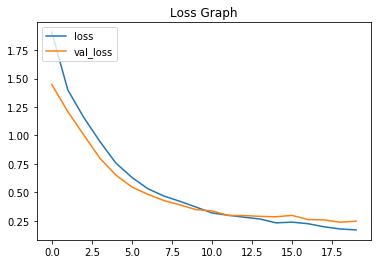

In [9]:
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [10]:
from sklearn.metrics import confusion_matrix,  accuracy_score
pre = model.predict_classes(x_test)
print("acc:", round(accuracy_score(y_test, pre)*100,2),"%")

pd.DataFrame(confusion_matrix(y_test, pre))


acc: 95.27 %


,0,1,2,3,4,5,6,7,8,9,10
0,22,1,0,0,0,0,0,0,0,0,0
1,1,122,3,0,0,0,0,0,0,0,0
2,0,0,119,1,0,1,1,0,0,0,0
3,0,0,2,65,0,0,0,0,0,0,0
4,0,0,1,1,75,0,1,0,1,0,0
5,0,0,1,0,1,74,1,2,0,0,0
6,0,0,0,0,0,2,65,3,0,0,0
7,0,0,1,0,0,1,0,70,4,0,0
8,0,0,0,0,0,0,0,4,90,3,0
9,0,0,0,0,0,0,0,0,0,50,1


In [11]:
y_pre = model.predict_classes(x)
y_m = []
trans_c_m = [-0.8,-0.6,-0.3,-0.15,-0.075,-0.025,0.025,0.075,0.15,0.3,0.6,0.8]
for i in range(len(y_pre)):
    y_m.append(trans_c_m[y_pre[i]])
y_real = y_raw

In [12]:
df = pd.DataFrame()
df["y_pre"] = y_m
df["y_real"] = y_real
df.to_csv("bt_0515.csv")